# 1 Imports

Note: please run the filter_raw.py script before completing this notebook

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calender
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima.utils import ndiffs, nsdiffs
from datetime import datetime
from ev_load_fc.config import CFG, resolve_path
from ev_load_fc.preprocessing.analysis import check_adf_stationarity
from ev_load_fc.preprocessing.preprocessing import mstl_resid_outlier


interim_data_path = resolve_path(CFG["paths"]["interim_data"])
ev_filt_path = interim_data_path / CFG["files"]["ev_filt_filename"]
weather_filt_path = interim_data_path / CFG["files"]["weather_filt_filename"]
traffic_filt_path = interim_data_path / CFG["files"]["traffic_filt_filename"]
aggperiod = CFG["data"]["preprocessing"]["aggregation_period"]
print(f"Data will be aggregated to a period of {aggperiod}")

min_timestamp = CFG['data']['raw_filters']['min_timestamp']
max_timestamp = CFG['data']['raw_filters']['max_timestamp']
# Build complete time index range
date_range = pd.date_range(start=min_timestamp, end=max_timestamp, freq=aggperiod)
print(f"Time series will cover the period from {min_timestamp} to {max_timestamp}")

Data will be aggregated to a period of 1h
Time series will cover the period from 2017-08-01 to 2020-03-01


In [2]:
ev_data = pd.read_csv(ev_filt_path, parse_dates=['start_date','end_date'])

# Create additional time-based columns
ev_data['month'] = ev_data['start_date'].dt.to_period('M')
ev_data['date'] = ev_data['start_date'].dt.date
ev_data['hourly_datetime'] = ev_data['start_date'].dt.round('h')
ev_data['weekday'] = ev_data['start_date'].dt.dayofweek

C:\Users\Cameron\AppData\Local\Temp\ipykernel_1740\499644708.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_data = pd.read_csv(ev_filt_path, parse_dates=['start_date','end_date'])


In [3]:
# Aggregate EV data with resampling to period of choice (e.g. 1h)
ev_load = (
    ev_data
        .set_index("hourly_datetime")
        .resample(aggperiod)["energy"]
        .sum()
        .reindex(date_range)
        .fillna(0)
        .sort_index()
)

In [4]:
print(f"% of time periods with zero EV load: {100 * (ev_load == 0).sum() / len(ev_load):.2f}%")

% of time periods with zero EV load: 27.17%


In [5]:
cal = calender()
holidays = cal.holidays(start=min_timestamp, end=max_timestamp, return_name=True)
holidays_df = holidays.reset_index().rename(columns={'index':'ds', 0:'holiday'})

# 2 Energy Load TSA 

## 2.1 Seasonal Decomposition

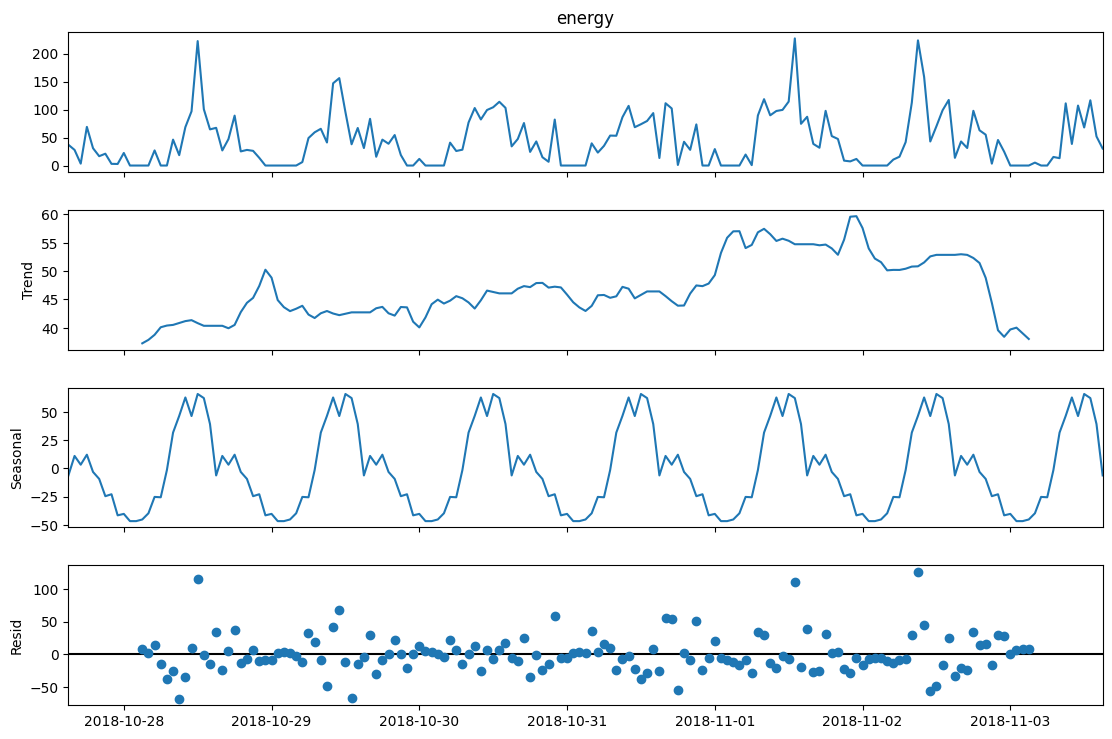

In [ ]:
snapshot_start = int(len(ev_load) * 0.48)
snapshot_end = snapshot_start+24*7+1 #int(len(ev_load) * 0.52)

result = seasonal_decompose(ev_load.iloc[snapshot_start:snapshot_end], period=None, model='additive')
fig = result.plot()
fig.set_size_inches(12, 8)

## 2.2 ADF test for stationarity (H0 = non-stationary)

In [ ]:
print(check_adf_stationarity(ev_load))
print(check_adf_stationarity(ev_load, 'ct'))
print(check_adf_stationarity(ev_load, 'ctt'))
# ADFS < 5% CV & p-value < 0.05 -> reject null hypothesis -> stationary for all 3 tests

ADF Statistic: -12.328102
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
None


KeyboardInterrupt: 

## 2.3 KPSS test for stationarity (H0 = level/trend stationary)

In [ ]:
kpss_result = kpss(ev_load.values, regression='c')
print(f"kpss_stat: {kpss_result[0]}")
print(f"p_value: {kpss_result[1]}")
print(f"lags: {kpss_result[2]}")
print(f"crit: {kpss_result[3]}")

kpss_stat: 15.273995971436287
p_value: 0.01
lags: 3
crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Cameron\AppData\Local\Temp\ipykernel_15096\217052551.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ev_load.values, regression='c')


In [ ]:
kpss_result_t = kpss(ev_load.values, regression='ct')
print(f"kpss_stat: {kpss_result_t[0]}")
print(f"p_value: {kpss_result_t[1]}")
print(f"lags: {kpss_result_t[2]}")
print(f"crit: {kpss_result_t[3]}")

kpss_stat: 0.05823967670620212
p_value: 0.1
lags: 17
crit: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


C:\Users\Cameron\AppData\Local\Temp\ipykernel_15096\2738112276.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_t = kpss(ev_load.values, regression='ct')


ADF test indicates stationarity (all H0 rejected with signficance level 5%) \
KPSS test indicates trend stationarity ('ct' failed to reject H0) but not level stationarity ('c' rejected H0)

## 2.4 ACF

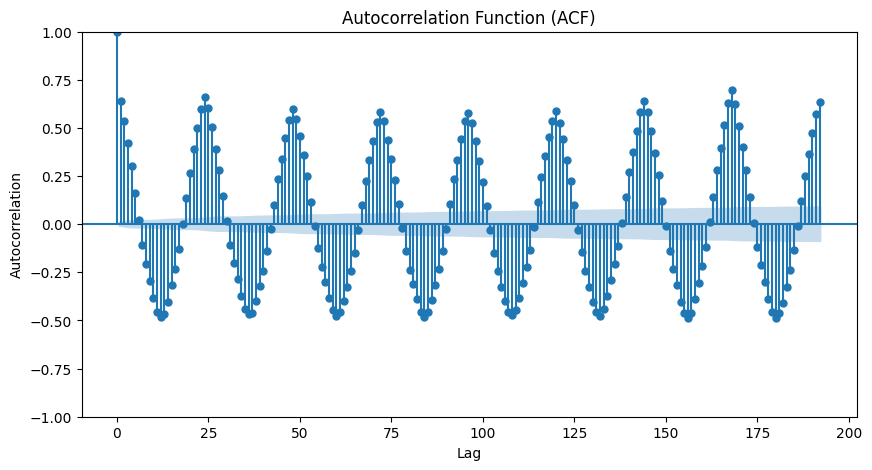

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ev_load, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF)")
plt.show() 

Strong daily seasonal effect

## 2.5 PACF

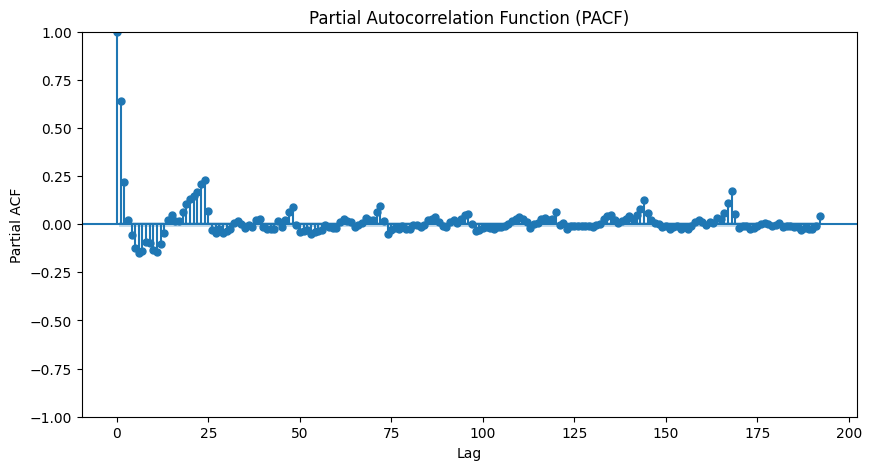

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ev_load, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Partial ACF")
ax.set_title("Partial Autocorrelation Function (PACF)")
plt.show() 

Significant correlations in the first 24h of lags, thereafter shows some minor correlation each 24hrs, especially on the 6th and 7th days

## 2.6 Rolling Mean

In [ ]:
ev_rm_daily  = ev_load.rolling(window=24).mean()
ev_rm_weekly = ev_load.rolling(window=7*24).mean()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_6416\3557254103.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


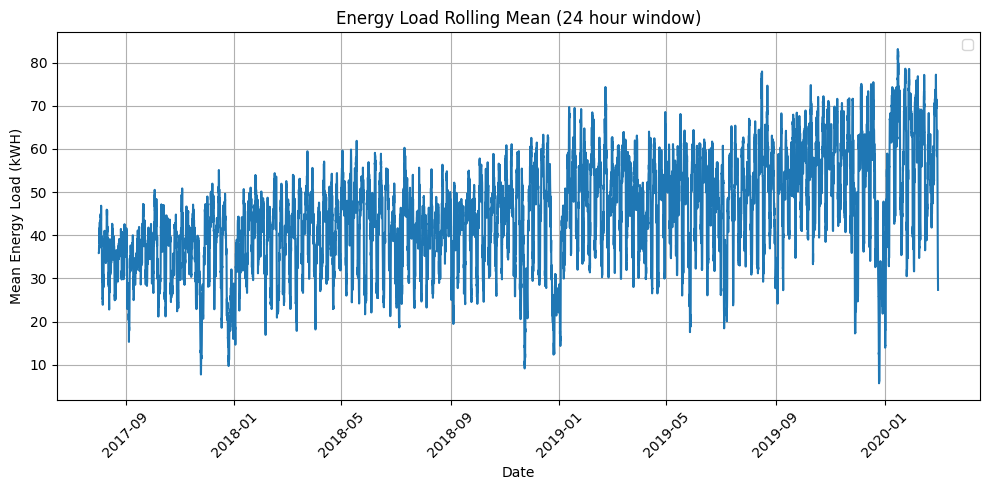

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_rm_daily.index, ev_rm_daily)
plt.title("Energy Load Rolling Mean (24 hour window)")
plt.xlabel("Date")
plt.ylabel("Mean Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()
plt.show()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_6416\2026454732.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


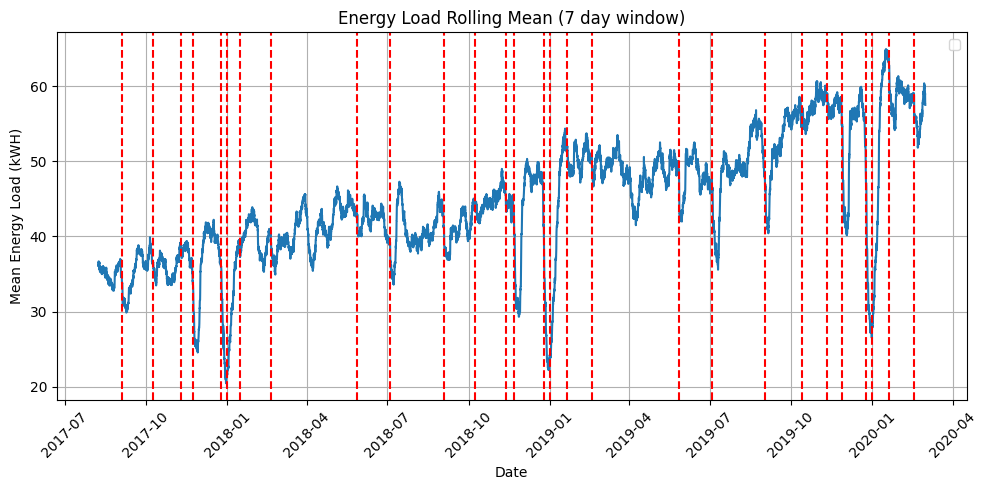

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_rm_weekly.index, ev_rm_weekly)
plt.title("Energy Load Rolling Mean (7 day window)")
plt.xlabel("Date")
plt.ylabel("Mean Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()

# Add vertical lines on major holidays
for date in holidays_df['ds']:
    plt.axvline(x=date, color='red', linestyle='--')

plt.show()

## 2.7 Rolling Variance

In [ ]:
ev_rv_daily  = ev_load.rolling(window=24).var()
ev_rv_weekly = ev_load.rolling(window=7*24).var()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_16564\845523166.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


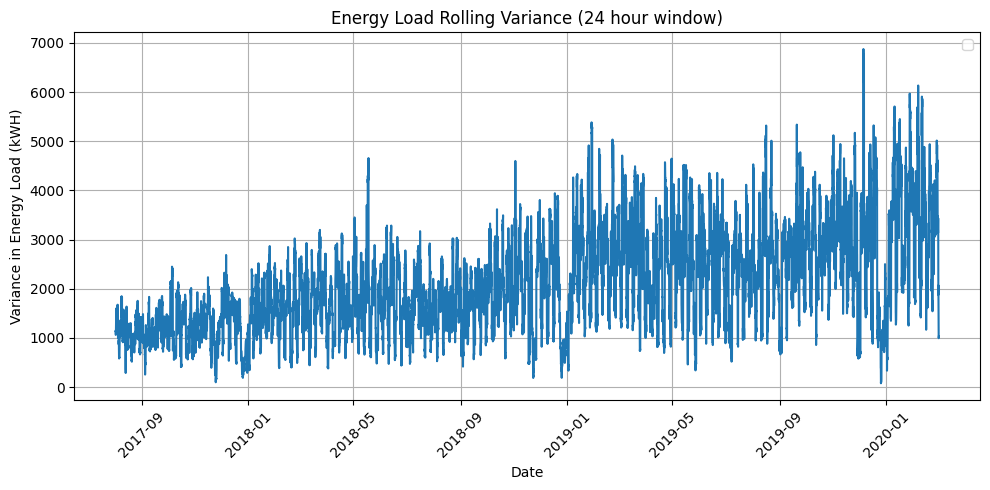

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_rv_daily.index, ev_rv_daily)
plt.title("Energy Load Rolling Variance (24 hour window)")
plt.xlabel("Date")
plt.ylabel("Variance in Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()
plt.show()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_16564\1083622062.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


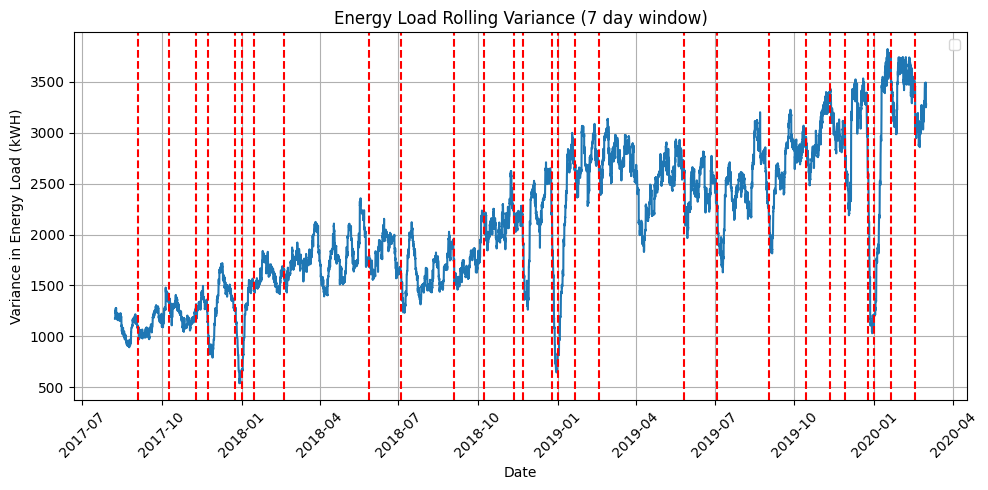

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_rv_weekly.index, ev_rv_weekly)
plt.title("Energy Load Rolling Variance (7 day window)")
plt.xlabel("Date")
plt.ylabel("Variance in Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()

# Add vertical lines on major holidays
for date in holidays_df['ds']:
    plt.axvline(x=date, color='red', linestyle='--')

plt.show()

# 3 Differenced Energy Load TSA

In [ ]:
diff_period = int(24 * (pd.Timedelta(aggperiod) / pd.Timedelta('1h')))
print(f"Differencing period (in hours): {diff_period}")

ev_load_diff = (ev_load-ev_load.shift(diff_period)).dropna()

Differencing period (in hours): 24


## 3.1 Seasonal Decomposition

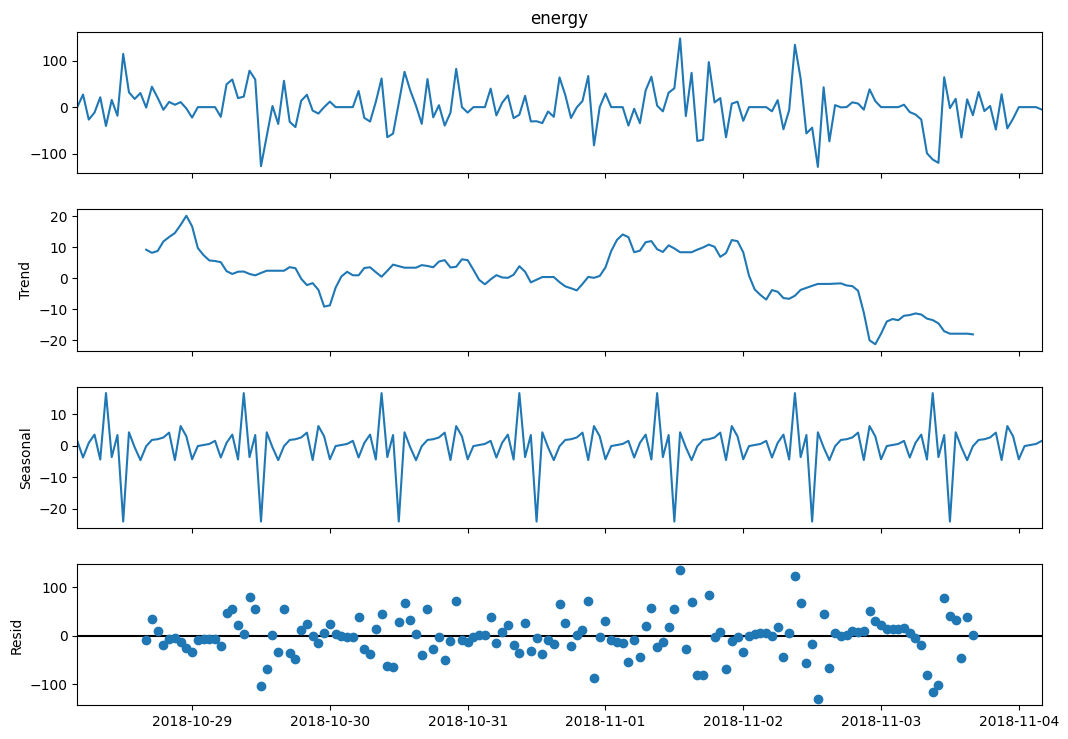

In [ ]:
snapshot_start = int(len(ev_load_diff) * 0.48)
snapshot_end = snapshot_start+24*7+1 #int(len(ev_load_diff) * 0.52)

result = seasonal_decompose(ev_load_diff.iloc[snapshot_start:snapshot_end], period=None, model='additive')
fig = result.plot()
fig.set_size_inches(12, 8)

## 3.2 ADF test for stationarity (H0 = non-stationary)

In [ ]:
print(check_adf_stationarity(ev_load_diff))
print(check_adf_stationarity(ev_load_diff, 'ct'))
print(check_adf_stationarity(ev_load_diff, 'ctt'))
# ADFS < 5% CV & p-value < 0.05 -> stationary for all 3 tests

ADF Statistic: -33.369997
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
None
ADF Statistic: -33.369131
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.411
	10%: -3.127
Stationary
None
ADF Statistic: -33.368880
p-value: 0.000000
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.553
Stationary
None


## 3.3 KPSS test for stationarity (H0 = level/trend stationary)

In [ ]:
kpss_result = kpss(ev_load_diff.values, regression='c')
print(f"kpss_stat: {kpss_result[0]}")
print(f"p_value: {kpss_result[1]}")
print(f"lags: {kpss_result[2]}")
print(f"crit: {kpss_result[3]}")

kpss_stat: 0.003698002208543604
p_value: 0.1
lags: 51
crit: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Cameron\AppData\Local\Temp\ipykernel_25504\1195278131.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ev_load_diff.values, regression='c')


In [ ]:
kpss_result_t = kpss(ev_load_diff.values, regression='ct')
print(f"kpss_stat: {kpss_result_t[0]}")
print(f"p_value: {kpss_result_t[1]}")
print(f"lags: {kpss_result_t[2]}")
print(f"crit: {kpss_result_t[3]}")

kpss_stat: 0.0023451357441319886
p_value: 0.1
lags: 51
crit: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


C:\Users\Cameron\AppData\Local\Temp\ipykernel_25504\1121982120.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_t = kpss(ev_load_diff.values, regression='ct')


## 3.4 ACF

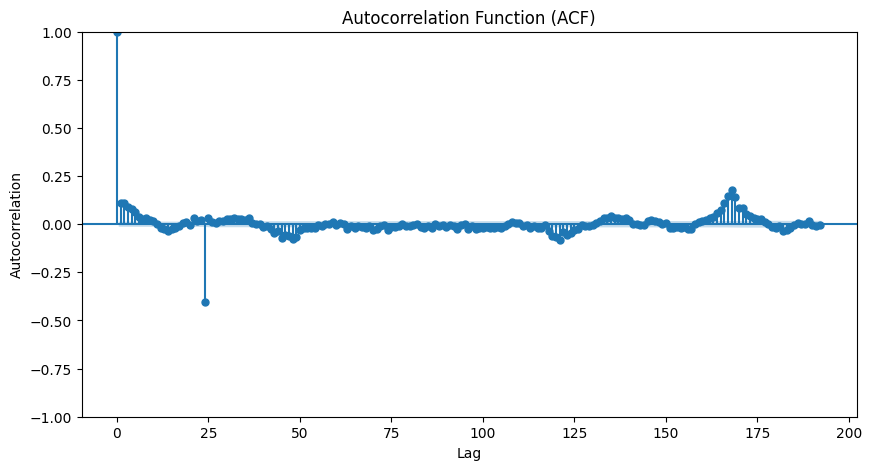

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ev_load_diff, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF)")
plt.show() 

Very clear negative correlation at 24hr lag, and shows weekly seasonality as well

## 3.5 PACF

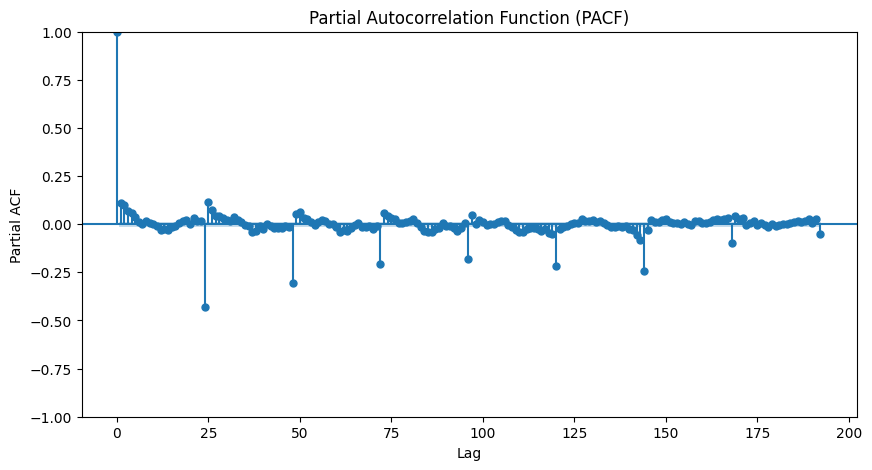

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ev_load_diff, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Partial ACF")
ax.set_title("Partial Autocorrelation Function (PACF)")
plt.show() 

Significant negative correlations at each 24hr lag

## 3.6 Rolling Mean

In [ ]:
ev_diff_rm_daily  = ev_load_diff.rolling(window=24).mean()
ev_diff_rm_weekly = ev_load_diff.rolling(window=7*24).mean()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_25504\3987440402.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


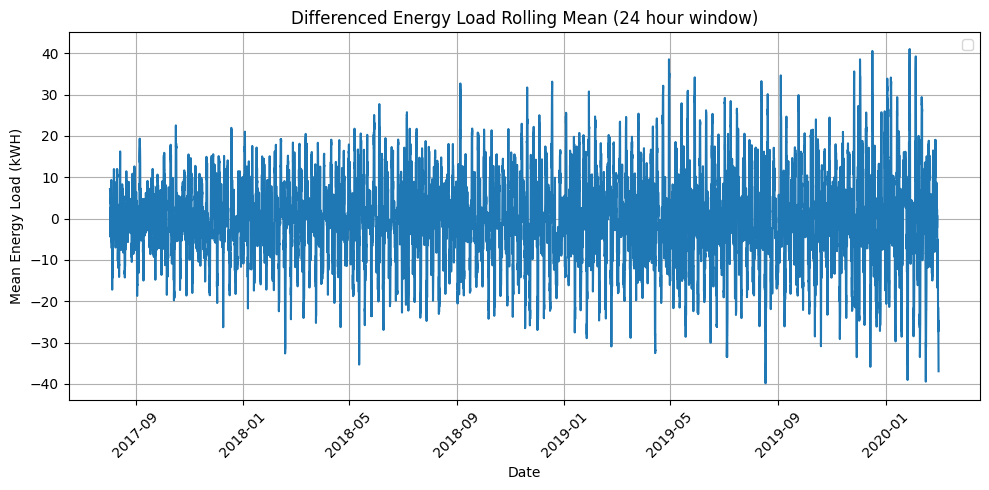

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_diff_rm_daily.index, ev_diff_rm_daily)
plt.title("Differenced Energy Load Rolling Mean (24 hour window)")
plt.xlabel("Date")
plt.ylabel("Mean Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()
plt.show()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_25504\1187586982.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


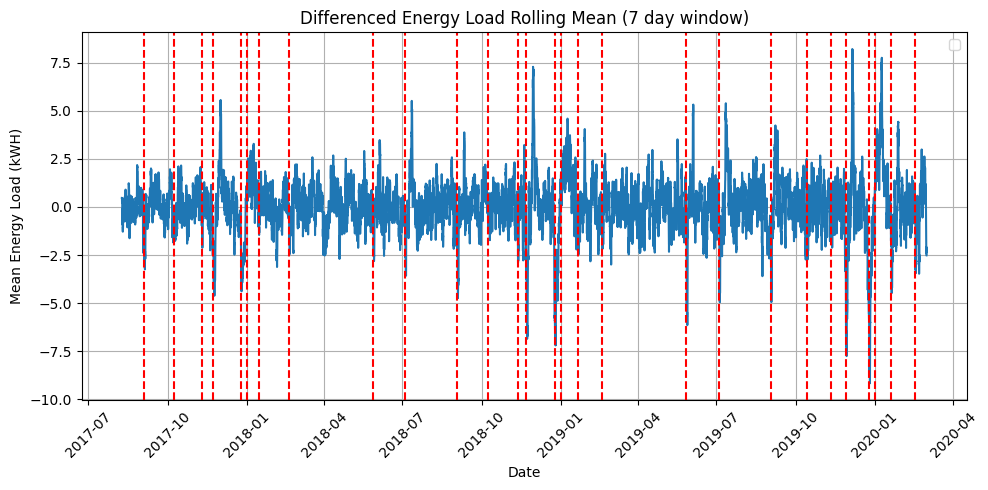

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_diff_rm_weekly.index, ev_diff_rm_weekly)
plt.title("Differenced Energy Load Rolling Mean (7 day window)")
plt.xlabel("Date")
plt.ylabel("Mean Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()

# Add vertical lines on major holidays
for date in holidays_df['ds']:
    plt.axvline(x=date, color='red', linestyle='--')

plt.show()

## 2.7 Rolling Variance

In [ ]:
ev_diff_rv_daily  = ev_load_diff.rolling(window=24).var()
ev_diff_rv_weekly = ev_load_diff.rolling(window=7*24).var()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_16564\3676200792.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


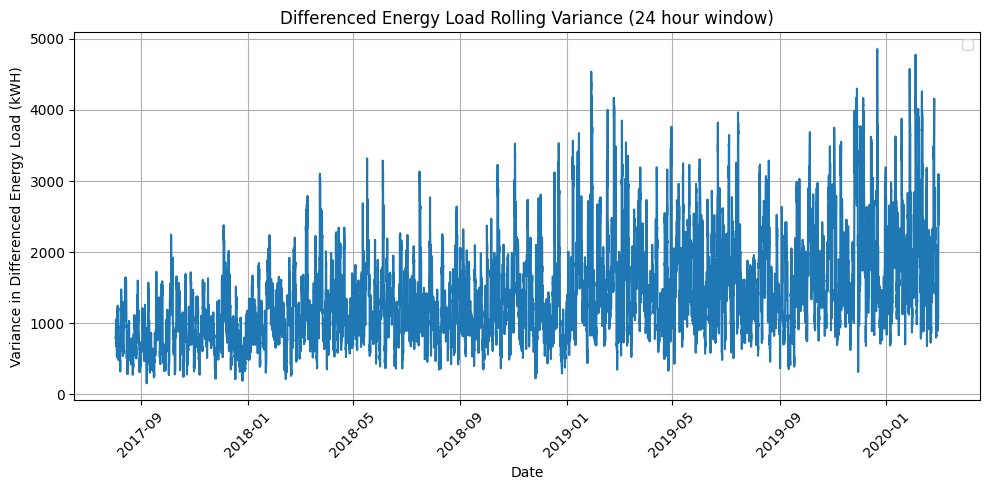

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_diff_rv_daily.index, ev_diff_rv_daily)
plt.title("Differenced Energy Load Rolling Variance (24 hour window)")
plt.xlabel("Date")
plt.ylabel("Variance in Differenced Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()
plt.show()

C:\Users\Cameron\AppData\Local\Temp\ipykernel_16564\427214745.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


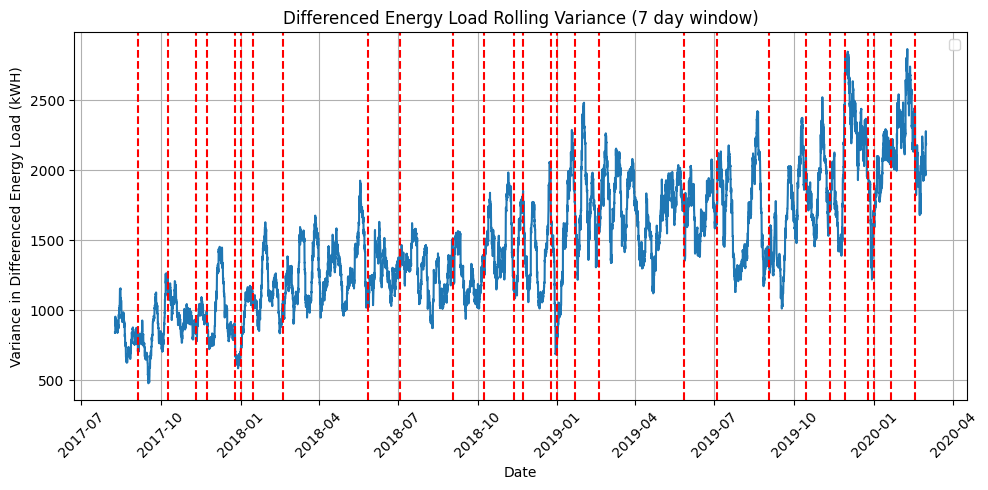

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ev_diff_rv_weekly.index, ev_diff_rv_weekly)
plt.title("Differenced Energy Load Rolling Variance (7 day window)")
plt.xlabel("Date")
plt.ylabel("Variance in Differenced Energy Load (kWH)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend() 
plt.tight_layout()

# Add vertical lines on major holidays
for date in holidays_df['ds']:
    plt.axvline(x=date, color='red', linestyle='--')

plt.show()

# 4 Residual analysis

## Perform MSTL

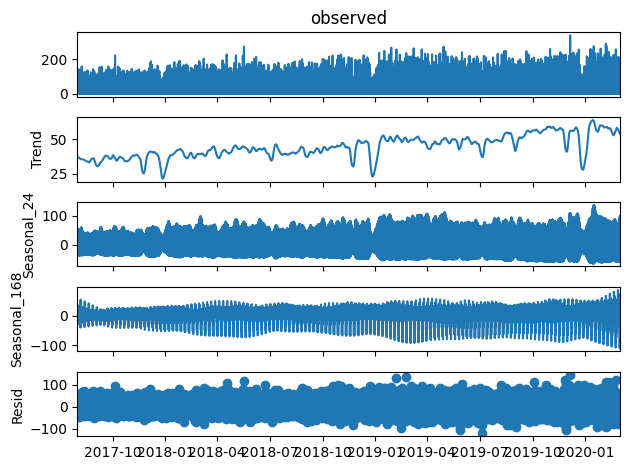

In [5]:
stl_model = MSTL(ev_load, periods=[24,24*7])
stl_res = stl_model.fit()
stl_res.plot()
plt.show()

resid = stl_res.resid

## ACF

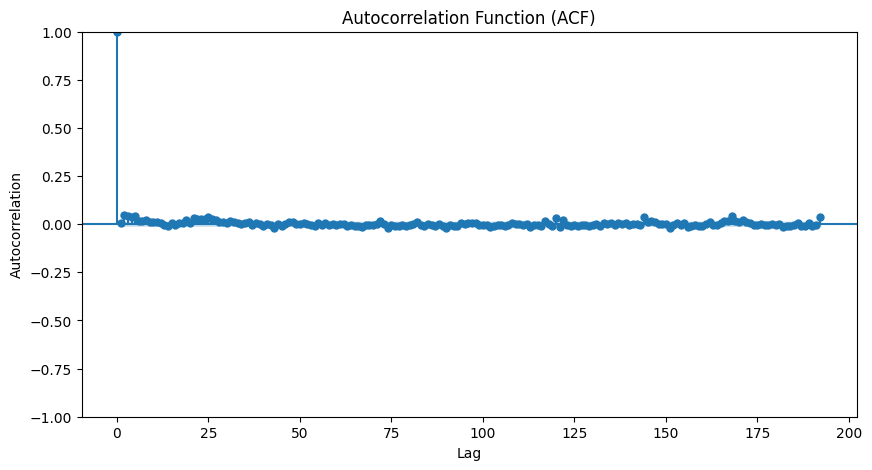

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(resid, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF)")
plt.show() 

## PACF

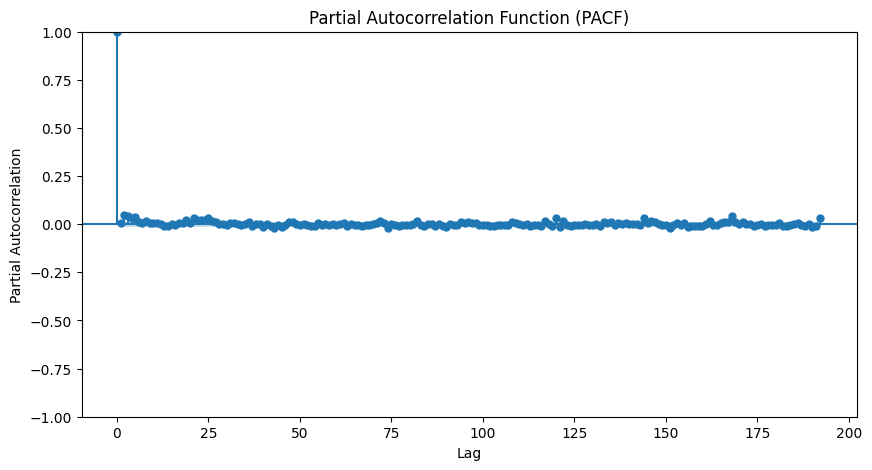

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(resid, lags=24*8, ax=ax) 
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
ax.set_title("Partial Autocorrelation Function (PACF)")
plt.show() 

## Caculate robust Z-score for residuals

In [6]:
median = np.median(resid)
mad = np.median(np.abs(resid - median))
sigma = 1.4826 * mad
k = 3.5
outliers = np.abs(resid - median) > k * sigma
print(sum(outliers))

980


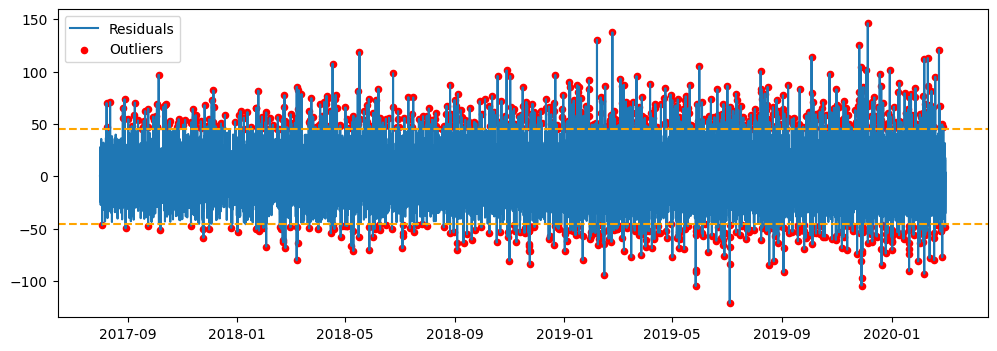

In [8]:
plt.figure(figsize=(12,4))

plt.plot(resid.index, resid.values, label="Residuals")

plt.scatter(
    resid.index[outliers],
    resid.values[outliers],
    color="red",
    s=20,
    label="Outliers"
)

plt.axhline(k * sigma, color="orange", linestyle="--")
plt.axhline(-k * sigma, color="orange", linestyle="--")

plt.legend()
plt.show()


## Build (S)ARIMA(X) on STL Residuals

Differencing orders d & D

In [11]:
# Optimal differencing order d
nd_adf = ndiffs(ev_load, test='adf')  
print(f"Recommended differencing order: {nd_adf}")

# Optimal seasonal differencing order D
nd_seasonal_adf = nsdiffs(ev_load,  m=7,  max_D=4, test='ch')  
print(f"Recommended seasonal differencing order: {nd_seasonal_adf}")

Recommended differencing order: 0
Recommended seasonal differencing order: 0


Holiday OHE

In [6]:
# Add extra holidays
extra_hols = pd.DataFrame({
    'ds': [
        datetime(2017,12,24),datetime(2018,12,24),datetime(2019,12,24),datetime(2017,12,26),datetime(2018,12,26),datetime(2019,12,26)
    ],
    'holiday': [
        'Christmas Eve','Christmas Eve','Christmas Eve','Boxing Day','Boxing Day','Boxing Day'
    ]
}   
)

holidays_df = pd.concat([holidays_df, extra_hols], axis=0)
# Expand holidays df to hourly basis
hours = pd.DataFrame({'hour': range(24)})
hourly_holidays_df = holidays_df.merge(hours, how='cross')
hourly_holidays_df['ds'] = hourly_holidays_df['ds'] + pd.to_timedelta(hourly_holidays_df['hour'], unit='h')


In [7]:
# Create hourly index across our date range
hourly_index = pd.date_range(start=min_timestamp, end=max_timestamp, freq='1h')  
ts = pd.DataFrame(index=hourly_index)
print(f"Range from {ts.index.min()} to {ts.index.max()}")

# Create One Hot Encodings for each holiday
holiday_ohe = pd.get_dummies(hourly_holidays_df.set_index('ds')['holiday'], dtype=int)
holiday_hourly = holiday_ohe.reindex(ts.index, fill_value=0)
holiday_hourly_cut = holiday_hourly[['Boxing Day','Christmas Day','Christmas Eve',"New Year's Day",'Thanksgiving Day','Independence Day']]

Range from 2017-08-01 00:00:00 to 2020-03-01 00:00:00


Fit and plot (S)ARIMA(X)

In [14]:
res_model = SARIMAX(
    resid,
    exog=holiday_hourly_cut,
    order=(2,0,2),
    # seasonal_order=(1,0,0,)
)
results = res_model.fit()

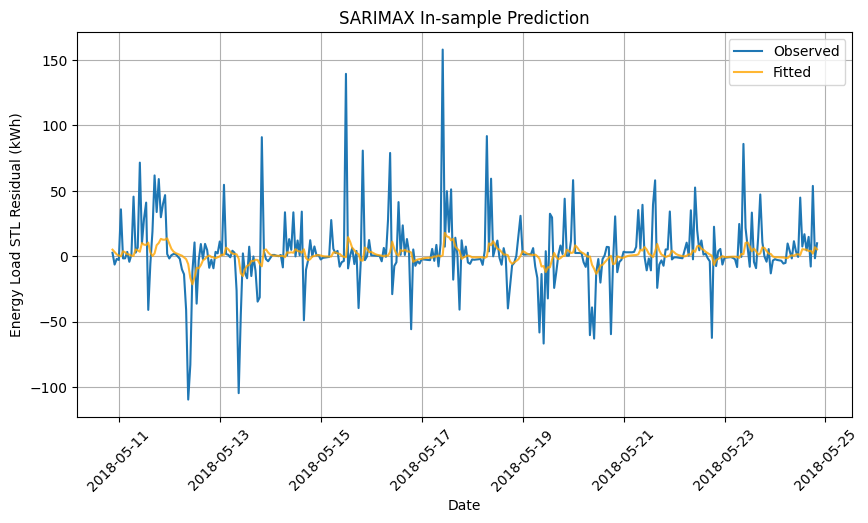

In [15]:
start_ind = int(len(resid) * 0.3)
end_ind   = start_ind+24*14 #int(len(resid) * 0.51)

pred = results.get_prediction(start=resid.index[0], end=resid.index[-1])
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(resid.iloc[start_ind:end_ind], label='Observed')
plt.plot(pred_mean.iloc[start_ind:end_ind], label='Fitted', color='orange', alpha=0.8)
# plt.fill_between(
#     pred_ci.index,
#     pred_ci.iloc[:, 0],
#     pred_ci.iloc[:, 1],
#     color='orange',
#     alpha=0.2
# )
plt.xlabel("Date")
plt.ylabel("Energy Load STL Residual (kWh)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.title("SARIMAX In-sample Prediction")
plt.show()


In [16]:
error = results.resid

med = np.median(error)
mad = np.median(np.abs(error - med))

scale = 1.4826 * mad
threshold = 3.5 * scale

z = (error - med) / scale
outliers = np.abs(z) > 3.5
print(f"% outliers: {(len(outliers)/len(z)):.2f}")

% outliers: 1.00


# 99 Conclusions

When checking the 1h (hourly) period aggregated time series for energy load, there is a clear daily seasonality for the original and differenced series. There is also noticeable weekly seasonalities.

The original series passes the ADF test for stationarity and the KPSS test for stationarity around a trend but fails for stationarity around a constant, additionally it clearly has an increasing rolling mean. \
Therefore we make the assumption that the time series is trend stationary i.e. it has stationary residuals with a deterministic trend.

The 24hr differenced series passes all tests for stationarity and has a non-increasing rolling mean.
Therefore we make the assumption it is level and trend stationary.

Thus differencing will most likely not be required for a (S)ARIMA model to perform well but should be tested.